# Fitting Thomson Scattering Spectrum

In [14]:
%matplotlib inline
import ts_analysis as TsA
import os

# s0808_18

### 1A: Load data and determine fibre positions on spectrometer CCD
First, you need to provide raw data in the form of a .asc file (plain ASCII, tab delimited) exported by Andor Solis for both the high power background and the shot. The background is used to calibrate the fibres. You can provide as many background files as you wish - the raw images are summed together. This is especially useful if you have pin scattering measurements for individual fibres, as the signal to noise ratio is far better than the high power background where the light scatters off particles in the vacuum chamber. To create a Thomson Scattering Analysis object, we use:

`ts=TsA.TS_Analysis('folder/shot_filename.asc',['folder/background_file1.asc','folder/background_file2.asc'])`

`ts` is an object that knows about the data in the files. `ts` starts by asking you where the fibre edges are. A graph appears on the screen with two sliders labelled `spacing` and `offset`. `spacing` is the number of pixels per fibres and `offset` is where the first fibre begins. Move the sliders so that the red dots lie in between each fibre in the minima. The default settings work well for most shots - you usually only need to adjust `offset`. It is difficult to get the red dots perfect for every fibre, but this only amounts to an error of 1 pixel, so it is not significant.


In [15]:
folder=r"C:\Users\jdhare\Google Drive\MAGPIE\data\2018\s0808_18 C reconnection strong drive\s0808_18 TS"
shot_fn='sh/s0808_18 shot.asc'
bk_fn='bk/s0808_18 hipower thru chamber.asc'
ts=TsA.TS_Analysis(folder, shot_fn,[bk_fn])
#You can write the correct spacing and offset here to remind yourself what to use when you rerun the code:
#spacing 17.8, offset 8

ts.find_fibre_edges()

A Jupyter Widget

### 1B: Specify fibre angles and split CCD into separate fibres
Once we have told `ts` where the fibre edges are, it can split the background and shot images into fibres and average over the pixels that correspond to each fibre:

`ts.split_into_fibres(discard_rows=0)` Discard rows is useful if light from different fibres overlaps, which is not an issue since since ~2016. If necessary for older data you can discard the first and last n rows of each fibre to avoid summing over contaminated data.

`ts.zero_fibres(upper=1150, lower=850)` Zero the fibres by subtracting the dark counts. Upper and lower ar ethe pixel numbers of the edge of the active CCD region, best leave them as the defaults.

`ts.pair_fibres(a_angle,b_angle)` pair the background and shot fibres together, assign an angle to each fibre bundle. a_angle and b_angle are lists of angles which are N fibres long, eg. [45,45...] 

In [16]:
ts.split_into_fibres(discard_rows=0)
ts.zero_fibres(upper=1150, lower=850)
a_angle=[45]*14 #here we have fibres 1A through 14A at an angle of 45'
b_angle=[135]*14
ts.pair_fibres(a_angle,b_angle)

### 2: Fit spectra
- Specify the fibre to fit using Fnum=(1-14) and Fset=('A' or 'B') (note quote marks)

- Leave the model as 'nLTE', no other models are currently implemented.

- Specify the plasma parameters in the form (Values, Independent?, Minimum value)

- If Independent is True, then the value is fixed and minimum has no meaning. If Independent is False, then the value is an initial guess for the fit and minimum is either a float, or simply ommitted to specify no given minimum.

- Leave A in brackets, eg 'A':  ((12), True). The code will find the relevant nLTE data for Z, T_e and decompose ZT_e into Z and T_e separately.

- If you're dealing with a narrow spectrum (spectrum is resolved by only ten pixels or so) there can be issues with convolution giving asymmetric peaks from symmetric functions (those with V_fe=0). To fix this, there is an interpolation subroutine which performs the convolution on a higher resolution model before comparing with data. In `f.fit_fibre()`, change the value of `interpolation_scale` to increase the number of points (10 is 10 times the number of points). This will dramatically slow down the code, but give more accurate answers. This should also give higher accuracy when trying to fit asymetric functions (where V_fe is not 0).

Once you've fitted the data, the code will remember the fit parameters it used, and instead of refitting you can simply plot or export the data using the next cells.

[[Model]]
    Model(Skw_nLTE_stray_light_convolve)
[[Fit Statistics]]
    # function evals   = 73
    # data points      = 296
    # variables        = 6
    chi-square         = 11133815.612
    reduced chi-square = 38392.468
    Akaike info crit   = 3130.401
    Bayesian info crit = 3152.543
[[Variables]]
    T_e:         69.2379433 +/- 1.606544 (2.32%) (init= 100)
    T_i:         287.579162 +/- 5.934038 (2.06%) (init= 150)
    V_fi:       -3045.33361 +/- 377.8756 (12.41%) (init= 0)
    stray:       3914.20437 +/- 178.7118 (4.57%) (init= 0.1)
    amplitude:   9553.62549 +/- 56.92774 (0.60%) (init= 10000)
    offset:      81.2897511 +/- 12.44632 (15.31%) (init= 120)
[[Correlations]] (unreported correlations are <  0.100)
    C(T_e, stray)                =  0.632 
    C(stray, amplitude)          = -0.618 
    C(T_e, T_i)                  = -0.578 
    C(T_e, amplitude)            = -0.470 
    C(T_i, stray)                = -0.423 
    C(amplitude, offset)         = -0.209 
    C(T_i

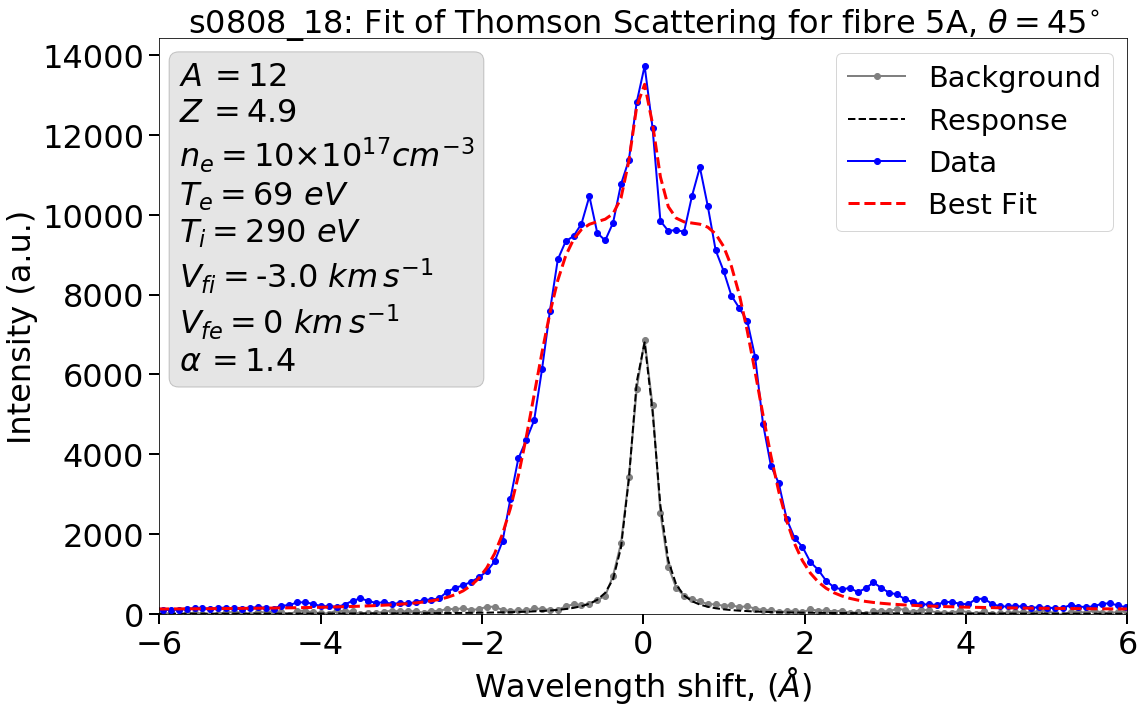

In [17]:
Fnum=5
Fset='A'

plasma_parameters={ 'model': 'nLTE',
                    'n_e': (1e18,True),#in cm^-3, must be specified
                    'T_e': (100, False,1),#In electron volts. 
                    'V_fe':(0, True),#m/s.
                    'A':  ((12), True),#in nucleon masses, must be specified
                    'T_i': (150, False,1),#In electron volts.
                    'V_fi':(0, False),#m/s.
                    'stray':(0.1, False,0), #Fraction of signal made up of stray light. >0, <1.0!!
                    'amplitude': (10000, False), #Fraction of signal made up of spectrum.
                    'offset': (120, False), #
                    'shift': (0, True)
                    }

'''This code fits and plots the result'''
f=ts.select_fibre(Fnum,Fset)
f.voigt_response()
f.symmetric_crop_around_l0()
f.fit_fibre(plasma_parameters, interpolation_scale=1)
f.calculate_alpha()
ts.pretty_plot(Fnum,Fset, tm=1.6, sr=6) #you can change the angstrom range plotted by altering 'sr=' here.
print(f.skw_res.fit_report()) #this prints the fitted values and the fit quality

### 3A: Plot data
If you've already fitted a fibre and simply want to see the fit again without refitting, use the cell below. You can then save the figure using the next cell. You can change the range of the horizontal access by altering sr=, which is in Angstroms

In [ ]:
ts.pretty_plot(Fnum=1,Fset='A', tm=1.6, sr=6)

### 3B: Save plot
This saves whichever figure you have generated last, either by fitting (2) or using the plot data cell (3A) above. You can alter the filename

In [ ]:
ts.fig.savefig(ts.s_name+' fibre '+str(Fnum)+Fset+'.png')

### 4: Export data
Save out the fits so you can plot them in another plotting program. Specify the fibre number and the fibre set.

In [ ]:
Fnum=1
Fset='A'
f.export_data(ts.s_name+' '+str(Fnum)+Fset)

### 5A: Plot all the A fibre data

In [ ]:
for i in range(1,15):
    ts.plot_data(Fnum=i, Fset='A')

### 5B: Plot all the B fibre data

In [ ]:
for i in range(1,15):
    ts.plot_data(Fnum=i, Fset='B')

In [18]:
f.lamb[150]-f.lamb[151]

-9.780000000007384e-12

In [21]:
f.vm_fit.best_values

{'amplitude': 2.1452175689017766e-07,
 'center': 5.3179307386898169e-07,
 'gamma': 1.0437539115080341e-11,
 'sigma': 9.53881418297442e-12}